## HW3 Starter Code: 524 Spring 2023

## Q1

In [1]:
using JuMP, HiGHS, LinearAlgebra
# 94 vehicles among 10 agencies

# Road distance is 1.3x Euclidean distance
# $0.50 per mile

# Describe movement of cars that allow the company to re-establish the required number of cars at all agencies
# Minimize total cost incurred for transport
agencies = [:one , :two, :three, :four, :five, :six, :seven, :eight, :nine, :ten]

# First entry is x coordinate, second is y coordinate
locations = Dict(
:one => [0, 0],
:two => [20, 20],
:three => [18, 10],
:four => [30, 12],
:five => [35, 0],
:six => [33, 25],
:seven => [5, 27],
:eight => [5, 10],
:nine => [11, 0],
:ten => [2, 15]
)

# First entry is required cars, second is cars currently present
cars = Dict(
:one => [10, 8],
:two => [6, 13],
:three => [8, 4],
:four => [11, 8],
:five => [9, 12],
:six => [7, 2],
:seven => [15, 14],
:eight => [7, 11],
:nine => [9, 15],
:ten => [12, 7]
);

In [2]:
# Decision variables are the flow of cars between agencies 
model = Model(HiGHS.Optimizer)

# car flows from a to b
@variable(model, edge[a in agencies, b in agencies] >= 0)
@variable(model, end_node[a in agencies] >= 0)

for a in agencies
    # SUPPLY CONSTRAINT:
    # Max out flow from each agency to others is less than or equal to the total number of cars it has
    @constraint(model, sum(edge[a, :]) <= cars[a][2])
    
    # DEMAND CONSTRAINTS:
    # The end node is calculated by summing over the edges transported to it plus its INITIAL VALUE minus its outflow
    @constraint(model, end_node[a] == sum(edge[:, a]) - sum(edge[a, :]) + cars[a][2])
    # The end_node must have this END VALUE
    @constraint(model, end_node[a] == cars[a][1])
end

# Only 94 total cars allowed
@constraint(model, sum(end_node) == 94)

# Minimize the costs
# Costs are distance between coordinates of two agencies * 1.3 * number of cars flowing between * 0.50 dollars per mile
@objective(model, Min, sum(edge[a, b]*norm(locations[a] - locations[b])*1.3*0.50 for a in agencies, b in agencies) )
optimize!(model)

println("\nMinimized Total Cost: ", objective_value(model))
println("\nEdge flows: ", value.(edge))

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
20 rows, 90 cols, 270 nonzeros
19 rows, 90 cols, 252 nonzeros
Presolve : Reductions: rows 19(-12); columns 90(-20); elements 252(-58)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 9(35) 0s
          9     1.5263901632e+02 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 9
Objective value     :  1.5263901632e+02
HiGHS run time      :          0.02

Minimized Total Cost: 152.63901632295628

Edge flows: 2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [:one, :two, :three, :four, :five, :six, :seven, :eight, :nine, :ten]
    Dimension 2, [:one, :two, :three, :four, :five, :six, :seven, :eight, :nine, :ten]
And data, a 10×10 Matrix{Float64}:
 0.0  0.0 

## Q2 Data for Stadium Building Problem

(This is the data needed for part (b). Part (a) of the problem will not need all this data.)

### Part A

In [3]:
tasks = 1:18
durations = [2 16 9 8 10 6 2 2 9 5 3 2 1 7 4 3 9 1]
predecessors = ( [], [1], [2], [2], [3], [4,5], [4], [6], [4,6], [4], [6], [9], [7], [2], [4,14], [8,11,14], [12], [17] )
pred_dict = Dict(zip(tasks,predecessors));   # dictionary mapping tasks --> predecessors.

# additional columns of data (maximum reduction possible )
max_reduction =  [0,  3,  1,  2,  2,  1, 1, 0,  2,  1,  1, 0, 0,  2,  2, 1,  3, 0]  # max reduction (in weeks)
cost_reduction = [0, 30, 26, 12, 17, 15, 8, 0, 42, 21, 18, 0, 0, 22, 12, 6, 16, 0]  # cost of reduction ($1,000/week)
bonus_amount = 30     # bonus for expediting the project ($1,000/week )

pred_dict;

In [4]:
# Decision variables are the starting times for each task
model = Model(HiGHS.Optimizer)

@variable(model, start_time[t in tasks] >= 0)
@variable(model, end_time >= 0)
# Making sure the start times are after the predecessors
for t in tasks
    for pred in pred_dict[t]
        @constraint(model, start_time[t] >= start_time[pred] + durations[pred])
    end
end
@constraint(model, start_time[1] == 0)
for t in tasks
    @constraint(model, end_time >= start_time[t] + durations[t])
end
# Minimize duration
@objective(model, Min, end_time)
optimize!(model)

prev_end_time = value(end_time)
println("\nEnd time: ", value(end_time), " Weeks")


Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
0 rows, 0 cols, 0 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-41); columns 0(-19); elements 0(-81) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  6.4000000000e+01
HiGHS run time      :          0.00

End time: 64.0 Weeks


### Part B

In [5]:
# Decision variables are the starting times for each task
#   AND how much we reduce the time in weeks
model = Model(HiGHS.Optimizer)

@variable(model, start_time[t in tasks] >= 0)
@variable(model, end_time >= 0)
@variable(model, 0 <= reductions[t in tasks] <= max_reduction[t])

# Making sure the start times are after the predecessors
for t in tasks
    for pred in pred_dict[t]
        @constraint(model, start_time[t] >= start_time[pred] + durations[pred] - reductions[pred])
    end
end
for t in tasks
    @constraint(model, end_time >= start_time[t] + durations[t] - reductions[t])
end
@constraint(model, start_time[1] == 0)

# Maximize profit
# --> Left hand is the profit from weeks in advance and right hand side is the cost of the reductions
@objective(model, Max, 30*(prev_end_time-end_time) - sum(cost_reduction[i]*reductions[i] for i in tasks))
optimize!(model)

println("\nEnd time: ", value(end_time), " Weeks")
println("Profit: ", objective_value(model), " Thousand Dollars")

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
40 rows, 31 cols, 110 nonzeros
25 rows, 17 cols, 85 nonzeros
12 rows, 11 cols, 53 nonzeros
9 rows, 9 cols, 55 nonzeros
5 rows, 5 cols, 12 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-41); columns 0(-37); elements 0(-121) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  8.7000000000e+01
HiGHS run time      :          0.00

End time: 57.0 Weeks
Profit: 87.0 Thousand Dollars


## Q3 Starter Code for Battery Charge Problem

#### Part A

In [6]:
m = Model(HiGHS.Optimizer)

capacity = 30
demand = [43 40 36 36 35 38 41 46 49 48 47 47 48 46 45 47 50 63 75 75 72 66 57 50]

@variable(m, 0 <= x[1:24] <= 50) # Battery power purchased at low rate
@variable(m, 0 <= y[1:24] <= 65) # Battery power purchased at high rate
@variable(m, 0 <= h[1:25] <= capacity) # Battery held in inventory

@constraint(m, h[1] == 0) # Starting battery is 0
@constraint(m, h[19] >= 20) # 10 MWh above maximum purchase in hours 19 and 20
for i in 1:24
    @constraint(m, h[i]+x[i]+y[i] == demand[i] + h[i+1])
end
@objective(m, Min, 100*sum(x) + 400*sum(y))  

optimize!(m)


println("\nLow Rate: ", value.(x))
println("\nHigh Rate: ", value.(y))
println("\nBattery Storage: ", value.(h))
println("\nTotal Cost: ", objective_value(m))

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
24 rows, 72 cols, 95 nonzeros
20 rows, 60 cols, 78 nonzeros
19 rows, 57 cols, 74 nonzeros
Presolve : Reductions: rows 19(-7); columns 57(-16); elements 74(-24)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     4.6999959820e+04 Pr: 19(895) 0s
         31     1.4340000000e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 31
Objective value     :  1.4340000000e+05
HiGHS run time      :          0.00

Low Rate: [50.0, 50.0, 19.0, 50.0, 50.0, 30.0, 50.0, 23.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]

High Rate: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 25.0, 25.0, 15.0, 0.0, 0.0, 0.0]

Battery Stor

#### Part B

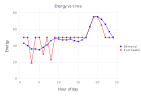

In [7]:
# this code will plot the demand (given in the starter code above) 
# and the value of the variable "purchased".
# Make sure the variable "purchased" is defined correctly by the code you write for part (a)
using Gadfly

purchased = value.(x) + value.(y)

plot(layer( x=1:24, y=value.(demand), Geom.point, Geom.line, Theme(default_color=colorant"blue") ),
    layer( x=1:24, y=value.(purchased), Geom.point, Geom.line, Theme(default_color=colorant"red") ),
    Guide.xlabel( "Hour of day"), 
    Guide.ylabel("Energy"), 
    Guide.title("Energy vs time"), 
    Guide.manual_color_key("",["Demand", "Purchased"], ["blue", "red"])
)

In [8]:
# During the 18th-21st hours it is necessary to purchase electricity at the higher rate

#### Part C

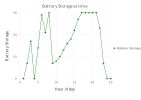

In [9]:
using Gadfly
plot(x=1:25, y=value.(h), Geom.point, Geom.line, Theme(default_color=colorant"green"),
    Guide.xlabel("Hour of day"), 
    Guide.ylabel("Battery Storage"), 
    Guide.title("Battery Storage vs time"), 
    Guide.manual_color_key("",["Battery Storage"], ["green"])
)

#### Part D

In [10]:
m = Model(HiGHS.Optimizer)

demand = [43 40 36 36 35 38 41 46 49 48 47 47 48 46 45 47 50 63 75 75 72 66 57 50]

@variable(m, 0 <= x[1:24] <= 50) # Battery power purchased at low rate
@variable(m, 0 <= y[1:24] <= 65) # Battery power purchased at high rate
@variable(m, 0 <= h[1:25] ) # Battery held in inventory -- NO CAPACITY

@constraint(m, h[1] == 0) # Starting battery is 0
@constraint(m, h[19] >= 20) # 10 MWh above maximum purchase in hours 19 and 20
for i in 1:24
    @constraint(m, h[i]+x[i]+y[i] == demand[i] + h[i+1])
end
@objective(m, Min, 100*sum(x) + 400*sum(y))  

optimize!(m)


println("\nLow Rate: ", value.(x))
println("\nHigh Rate: ", value.(y))
println("\nBattery Storage: ", value.(h))
println("\nTotal Cost: ", objective_value(m))

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
24 rows, 72 cols, 95 nonzeros
24 rows, 72 cols, 95 nonzeros
Presolve : Reductions: rows 24(-2); columns 72(-1); elements 95(-3)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     7.3904305900e-05 Pr: 24(1200) 0s
         24     1.2000000000e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 24
Objective value     :  1.2000000000e+05
HiGHS run time      :          0.00

Low Rate: [50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]

High Rate: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Battery Storage: [-0.0, 7.0, 17.0, 31.0, 45.0, 

In [11]:
# The maximum storage held in the battery was 108 MWh

#### Part E

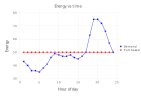

In [12]:
purchased = value.(x) + value.(y)

plot(layer( x=1:24, y=value.(demand), Geom.point, Geom.line, Theme(default_color=colorant"blue") ),
    layer( x=1:24, y=value.(purchased), Geom.point, Geom.line, Theme(default_color=colorant"red") ),
    Guide.xlabel( "Hour of day"), 
    Guide.ylabel("Energy"), 
    Guide.title("Energy vs time"), 
    Guide.manual_color_key("",["Demand", "Purchased"], ["blue", "red"])
)

It is never necessary to purchase electricity at the higher rate in this case

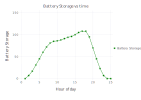

In [13]:
plot(x=1:25, y=value.(h), Geom.point, Geom.line, Theme(default_color=colorant"green"),
    Guide.xlabel("Hour of day"), 
    Guide.ylabel("Battery Storage"), 
    Guide.title("Battery Storage vs time"), 
    Guide.manual_color_key("",["Battery Storage"], ["green"])
)